# Zillow.com Webscraper

In [1]:
import os
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import regex as re
import requests
import re
import sklearn
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment',None)
headers = {
    'authority': 'www.zillow.com',
    'sec-ch-ua': '"Google Chrome";v="89", "Chromium";v="89", ";Not A Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36',
    'accept': '*/*',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://www.zillow.com/homes/Layton,-UT_rb/',
    'accept-language': 'en-US,en;q=0.9',
}


#NB. Original query string below. It seems impossible to parse and
#reproduce query strings 100% accurately so the one below is given
#in case the reproduced version is not "correct".
# response = requests.get('https://www.zillow.com/search/GetSearchPageState.htm?searchQueryState=%7B%22pagination%22%3A%7B%22currentPage%22%3A2%7D%2C%22

## Make the Request

In [2]:
with requests.session() as s:
    city = 'layton/'
    page = 1
    end_page = 10
    url = ''
    url_list = []
    
    while page <= end_page:
        url = 'https://www.zillow.com/homes/for_sale/' +city+ f'{page}_p/'
        url_list.append(url)
        page += 1
    
    request = ''
    request_list = []
    
    for url in url_list:
        request = s.get(url, headers=headers)
        request_list.append(request)
    
soup = ''
soup_list = []

for request in request_list:
    soup = BeautifulSoup(request.content, 'html.parser')
    soup_list.append(soup)

In [3]:
#soup_list[0]

## Parse the soup

In [4]:
df_list = []
cnt = 0
for soup in soup_list:
    df = pd.DataFrame()

#    for i in soup:
#         last_updated = soup.find_all ('div', {'class': 'list-card-top'})
#         brokerage = list(soup.find_all(class_= 'list-card-brokerage list-card-img-overlay',text=True))

    prices = []
    addresses = []        
    urls = []
    bedrooms = []
    bathrooms = []
    squareFeet = []
    types = []
    
    for link in soup.find_all("article"):
        # Get the Address
        #print(link)
        tag = link.find('a',class_="property-card-link")
        # print("Tag: ", tag)
        href = tag['href']
        #print(href)
        address = tag.find('address').text

        # Get the link
        tag = link.find(class_="list-card-addr")
        urls.append(href)
        
        # Get the price
        string = re.search("StyledPropertyCardDataArea-c11n-8-69-2__sc-yipmu-0 kJFQQX", str(link)).group(0)
        tag = link.find('div', class_="StyledPropertyCardDataArea-c11n-8-69-2__sc-yipmu-0 kJFQQX")
        price = tag.find('span')
        price = tag.select_one("span[data-test*=price]").text
        
        # Other details (bedrooms, bathrooms, square footage)
        details = link.find('span', class_="StyledPropertyCardHomeDetails-c11n-8-69-2__sc-1mlc4v9-0 ereqYj")
        details = details.find_all('span')

        #print(details[0])
        beds = re.findall(r'\d+', str(details[0].text))
        if beds:
            pass
        else:
            beds = '0'
        
        try:
            baths = re.findall(r'\d+', str(details[1].text))
        except:
            baths = '0'
        #print(details[1])
        #print(baths)
        if baths:
            pass
        else:
            baths = '0'

        for i in range(3):
            #print(i)
            try:
                if 'sqft' in str(details[i].text):
                    sqft = re.findall(r'\d+,?\d+', str(details[i].text))
                    #print(sqft)
                    break
            except:
                pass

        home_type_text = link.find('div', class_="StyledPropertyCardDataArea-c11n-8-69-2__sc-yipmu-0 bKFUMJ").text
        #print(home_type_text)
            
        if 'Lot' in home_type_text:
            types.append('Lot')
        elif 'Multi' in home_type_text:
            types.append('Multi-Family Home')
        elif 'Town' in home_type_text:
            types.append('Town House')
        elif 'Condo' in home_type_text:
            types.append('Condo')
        elif 'Apartment' in home_type_text:
            types.append('Apartment')
        else:
        #if 'Single' in home_type_text:
            types.append('Single-Family Home')
            
        #print('Home type: ', home_type)
        
        addresses.append(address)
        prices.append(price)
        bedrooms.append(beds[0])
        bathrooms.append(baths[0])
        try:
            squareFeet.append(sqft[0])
        except:
            squareFeet.append('0')

        cnt += 1
        
    df['address'] = addresses
    df['price'] = prices
    print(prices)
    df['beds'] = bedrooms
    df['baths'] = bathrooms
    df['sqft'] = squareFeet
    print(types)
    df['type'] = types
    df['links'] = urls
    df['links'] = df['links'].astype('str')
    df['links'] = df['links'].replace('<a class="list-card-link list-card-link-top-margin" href="', ' ', regex=True)
    df['links'] = df['links'].replace('" tabindex="0"></a>', ' ', regex=True)
    df_list.append(df)

['$460,000', '$489,900', '$499,900', '$374,900', '$639,900', '$540,000', '$415,000', '$469,900', '$630,000']
['Single-Family Home', 'Town House', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home']
['$630,000', '$505,000', '$435,000', '$79,900', '$650,000', '$435,000', '$575,000', '$725,000', '$739,999']
['Single-Family Home', 'Single-Family Home', 'Town House', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home']
['$89,000', '$499,900', '$450,000', '$719,900', '$379,000', '$879,000', '$385,000', '$515,000', '$494,000']
['Single-Family Home', 'Single-Family Home', 'Town House', 'Single-Family Home', 'Town House', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home', 'Single-Family Home']
['$127,000', '$1,275,000', '$644,900', '$719,900', '$392,000', '$499,900', '$732,600', '$575,000', '$749,900']

In [5]:
df_list[0]

,address,price,beds,baths,sqft,type,links
0,"1018 W 2600 N, Layton, UT 84041","$460,000",4,4,"2,058",Single-Family Home,https://www.zillow.com/homedetails/1018-W-2600...
1,"2239 N 475 W #25, Layton, UT 84041","$489,900",4,3,"2,104",Town House,https://www.zillow.com/homedetails/2239-N-475-...
2,"1417 N 2475 W, Layton, UT 84041","$499,900",4,4,"2,103",Single-Family Home,https://www.zillow.com/homedetails/1417-N-2475...
3,"1006 W 2200 N, Layton, UT 84041","$374,900",4,2,"1,889",Single-Family Home,https://www.zillow.com/homedetails/1006-W-2200...
4,"147 E 975 S, Layton, UT 84041","$639,900",4,3,"3,242",Single-Family Home,https://www.zillow.com/homedetails/147-E-975-S...
5,"146 S 1125 W, Layton, UT 84041","$540,000",6,3,"2,574",Single-Family Home,https://www.zillow.com/homedetails/146-S-1125-...
6,"1456 E Kayscreek Dr #42, Layton, UT 84040","$415,000",4,3,"2,991",Single-Family Home,https://www.zillow.com/homedetails/1456-E-Kays...
7,"1988 E 1300 N, Layton, UT 84040","$469,900",4,3,"2,472",Single-Family Home,https://www.zillow.com/homedetails/1988-E-1300...
8,"2453 W Sunburst Dr, Layton, UT 84041","$630,000",6,3,"3,225",Single-Family Home,https://www.zillow.com/homedetails/2453-W-Sunb...


In [6]:
df = pd.concat(df_list).reset_index().drop(columns='index')

In [7]:
df

,address,price,beds,baths,sqft,type,links
0,"1018 W 2600 N, Layton, UT 84041","$460,000",4,4,"2,058",Single-Family Home,https://www.zillow.com/homedetails/1018-W-2600...
1,"2239 N 475 W #25, Layton, UT 84041","$489,900",4,3,"2,104",Town House,https://www.zillow.com/homedetails/2239-N-475-...
2,"1417 N 2475 W, Layton, UT 84041","$499,900",4,4,"2,103",Single-Family Home,https://www.zillow.com/homedetails/1417-N-2475...
3,"1006 W 2200 N, Layton, UT 84041","$374,900",4,2,"1,889",Single-Family Home,https://www.zillow.com/homedetails/1006-W-2200...
4,"147 E 975 S, Layton, UT 84041","$639,900",4,3,"3,242",Single-Family Home,https://www.zillow.com/homedetails/147-E-975-S...
5,"146 S 1125 W, Layton, UT 84041","$540,000",6,3,"2,574",Single-Family Home,https://www.zillow.com/homedetails/146-S-1125-...
6,"1456 E Kayscreek Dr #42, Layton, UT 84040","$415,000",4,3,"2,991",Single-Family Home,https://www.zillow.com/homedetails/1456-E-Kays...
7,"1988 E 1300 N, Layton, UT 84040","$469,900",4,3,"2,472",Single-Family Home,https://www.zillow.com/homedetails/1988-E-1300...
8,"2453 W Sunburst Dr, Layton, UT 84041","$630,000",6,3,"3,225",Single-Family Home,https://www.zillow.com/homedetails/2453-W-Sunb...
9,"987 E Mountain Shadow Dr, Layton, UT 84040","$630,000",4,3,"2,812",Single-Family Home,https://www.zillow.com/homedetails/987-E-Mount...


In [8]:
df.to_csv('ZillowData.csv')

In [9]:
if df['price'].dtype != int:
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].str.replace('+', '')    
    df['price'] = pd.to_numeric(df['price'])

if df['sqft'].dtype != int:
    df['sqft'] = df['sqft'].str.replace(',', '')
    df['sqft'] = pd.to_numeric(df['sqft'])
    
df.dtypes

/tmp/ipykernel_309/3354885827.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '')
/tmp/ipykernel_309/3354885827.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('+', '')


address    object
price       int64
beds       object
baths      object
sqft        int64
type       object
links      object
dtype: object

In [10]:
sfh_df = df[df['type'] == 'Single-Family Home']

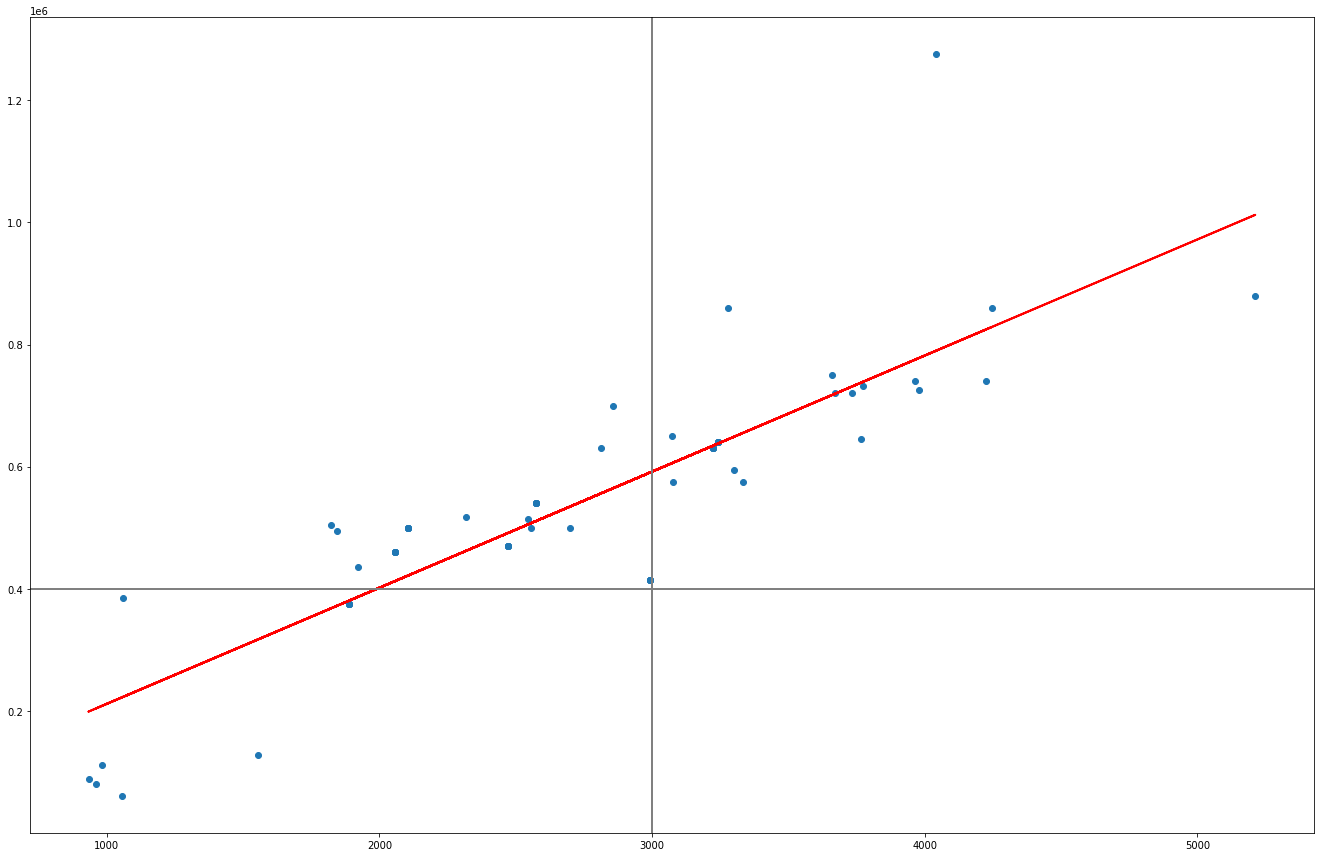

In [11]:
a, b = np.polyfit(sfh_df['sqft'], sfh_df['price'], 1)

plt.rcParams["figure.figsize"] = (23,15)
plt.scatter(sfh_df['sqft'], sfh_df['price'])
plt.plot(sfh_df['sqft'], a*sfh_df['sqft']+b, color='red', linewidth=2)
plt.axvline(3000, color='gray', linewidth=2)
plt.axhline(400000, color='gray', linewidth=2)